In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from matplotlib import pyplot
from keras import regularizers

Using TensorFlow backend.


In [2]:
# This function will convert the timeseries data to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
# Here, we use the cleaned data from cleaned_data.csv file
# We have removed redundant columns, and removed rows with NAN values
df = pd.read_csv('cleaned_data.csv', index_col = 0)
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
1/2/10 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1/2/10 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
1/2/10 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
1/2/10 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
1/2/10 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
values = df.values
# Encode the categorical wnd_dir column with LabelEncoder 
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# Normalize the values by scaling
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)
# Convert the timeseries data into supervised learning
reframed = series_to_supervised(scaled)
# Drop non-required columns
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [5]:
# Split the dataet into test and train
values = reframed.values
n_train_hours = 365 * 24 * 2
train = values[: n_train_hours, :]
test = values[n_train_hours :, :]
train_X = train[:, : -1]
train_y = train[:, -1]
test_X = test[:, : -1]
test_y = test[:, -1]

In [6]:
# LSTM requires the input format as 3D format, [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17520, 1, 8) (17520,) (26279, 1, 8) (26279,)


Train on 17520 samples, validate on 26279 samples
Epoch 1/50
2s - loss: 0.4023 - val_loss: 0.0871
Epoch 2/50
2s - loss: 0.0700 - val_loss: 0.0597
Epoch 3/50
2s - loss: 0.0376 - val_loss: 0.0400
Epoch 4/50
1s - loss: 0.0246 - val_loss: 0.0288
Epoch 5/50
1s - loss: 0.0227 - val_loss: 0.0206
Epoch 6/50
1s - loss: 0.0213 - val_loss: 0.0194
Epoch 7/50
2s - loss: 0.0205 - val_loss: 0.0191
Epoch 8/50
1s - loss: 0.0203 - val_loss: 0.0191
Epoch 9/50
1s - loss: 0.0201 - val_loss: 0.0194
Epoch 10/50
2s - loss: 0.0201 - val_loss: 0.0194
Epoch 11/50
2s - loss: 0.0199 - val_loss: 0.0195
Epoch 12/50
1s - loss: 0.0200 - val_loss: 0.0195
Epoch 13/50
1s - loss: 0.0197 - val_loss: 0.0194
Epoch 14/50
1s - loss: 0.0198 - val_loss: 0.0194
Epoch 15/50
2s - loss: 0.0195 - val_loss: 0.0187
Epoch 16/50
1s - loss: 0.0195 - val_loss: 0.0192
Epoch 17/50
2s - loss: 0.0195 - val_loss: 0.0183
Epoch 18/50
2s - loss: 0.0192 - val_loss: 0.0196
Epoch 19/50
2s - loss: 0.0195 - val_loss: 0.0189
Epoch 20/50
1s - loss: 0.019

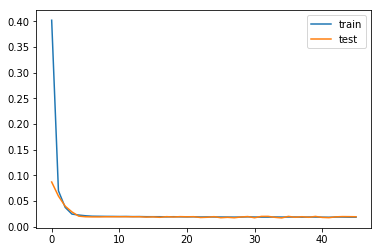

In [7]:
model = Sequential()
model.add(LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]), kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(50), )
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')
early_stopping_monitor = EarlyStopping(patience = 10)
history = model.fit(train_X, train_y, epochs = 50, batch_size = 72, validation_data = (test_X, test_y), verbose = 2, shuffle = False, callbacks = [early_stopping_monitor])
pyplot.figure()
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

In [38]:
# save this model
model.save('model.h5')